(<Axes: title={'center': 'kms'}>,
 Text(0.5, 1.0, 'kms'))

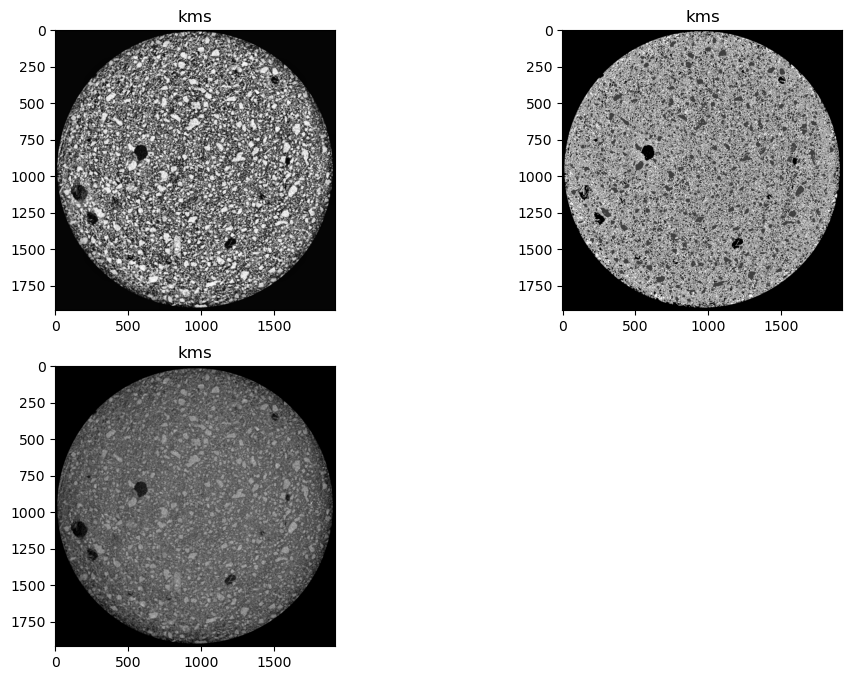

In [2]:
# 图像配准Step1，后面再给它整合到一个类中
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_enhanced.image_preprocess import ImageProcess
from utils.tools import Tools
from utils.visualize import VisualizeData

config = Tools.load_yaml_config("preprocess_config.yaml")

imageProcess = ImageProcess(config)

root_path = "G:/CT/4/Reconstruction"
save_path = "D:/workspace/ml-workspace/registration/datasets/sample4/bse/s2/100"
file_name = "4-1-1"

file_path = f"{root_path}/4-_IR_rec00000545.bmp"
ct_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

enhanced_ct = imageProcess.enhanced_ct(ct_img)
cls_ct = imageProcess.segment_ct(enhanced_ct, 5)

cv2.imwrite(f'{save_path}/{file_name}-ct-masked.bmp', cls_ct)
cv2.imwrite(f'{save_path}/{file_name}-ct-enhanced.bmp', enhanced_ct)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(enhanced_ct, cmap='gray',vmin=0, vmax=255), plt.title('kms')
plt.subplot(2, 2, 2), plt.imshow(cls_ct, cmap='gray',vmin=0, vmax=255), plt.title('kms')
plt.subplot(2, 2, 3), plt.imshow(ct_img, cmap='gray',vmin=0, vmax=255), plt.title('kms')


(<Axes: title={'center': 'filtered_image'}>,
 Text(0.5, 1.0, 'filtered_image'))

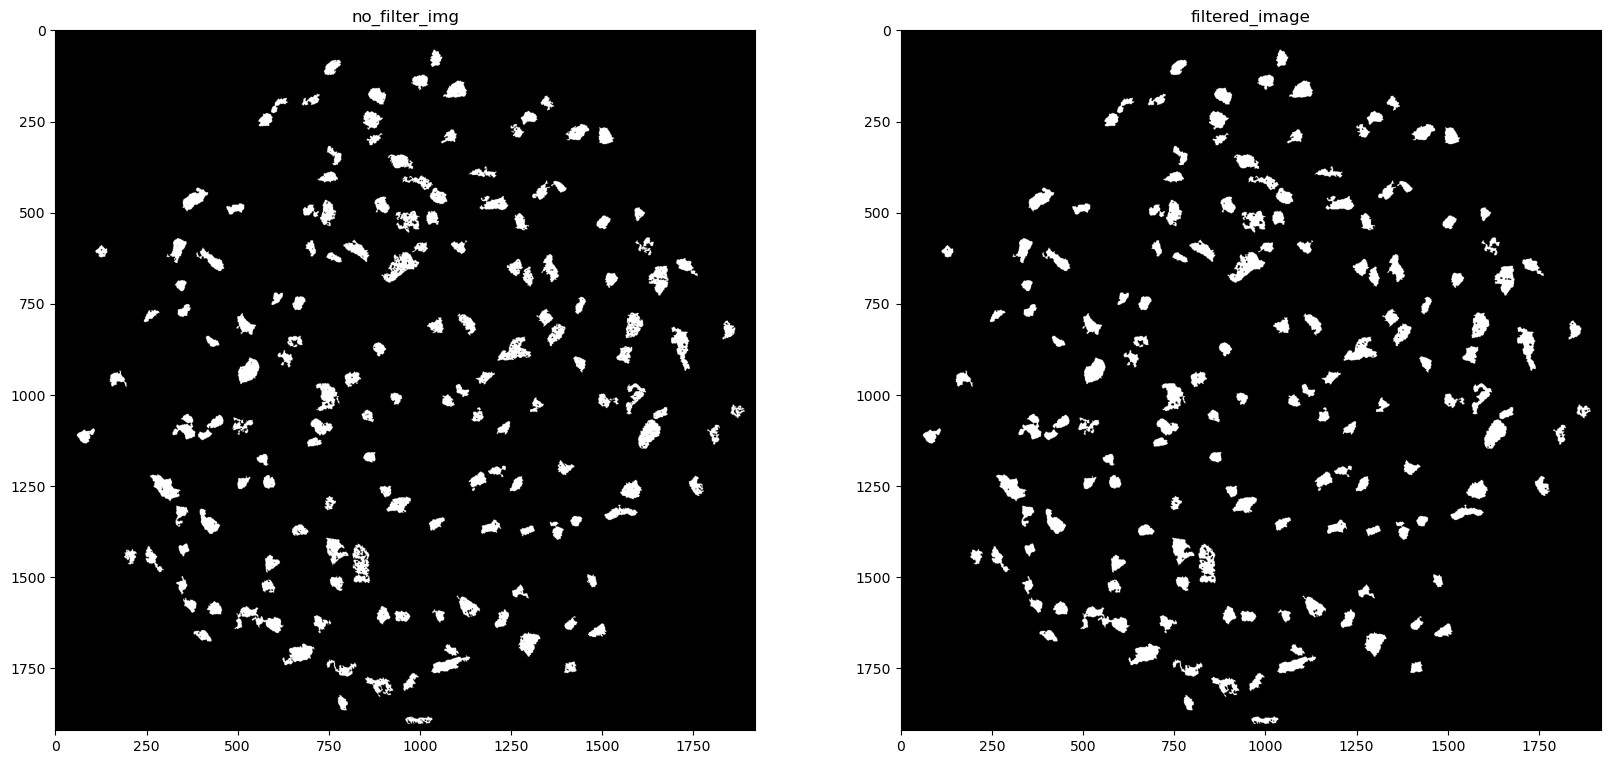

In [4]:
gray_cls = 63

kms = cls_ct.copy()

neg_cls = kms != gray_cls
positive_cls = kms == gray_cls
kms[neg_cls] = 0
kms[positive_cls] = 255

bin_image = kms

# 寻找连通区域
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_image, 4, cv2.CV_32S)

# 设置大小阈值
size_threshold = 624

# 创建一个新的图像来存放结果
new_image = np.zeros_like(bin_image)

# 遍历所有连通区域
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= size_threshold:
        # 如果连通区域的大小大于阈值，则将其添加到新图像中
        new_image[labels == i] = 255

no_filter_img = np.copy(new_image)

kms = new_image
# 定义核（kernel）的大小
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 膨胀操作
dilated_image = cv2.dilate(kms, kernel, iterations=1)

# 腐蚀操作
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
new_image = eroded_image

cv2.imwrite(f'{save_path}/{file_name}-ct-masked.bmp', new_image)

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1), plt.imshow(no_filter_img, cmap='gray',vmin=0, vmax=255), plt.title('no_filter_img')
plt.subplot(2, 2, 2), plt.imshow(new_image, cmap='gray',vmin=0, vmax=255), plt.title('filtered_image')

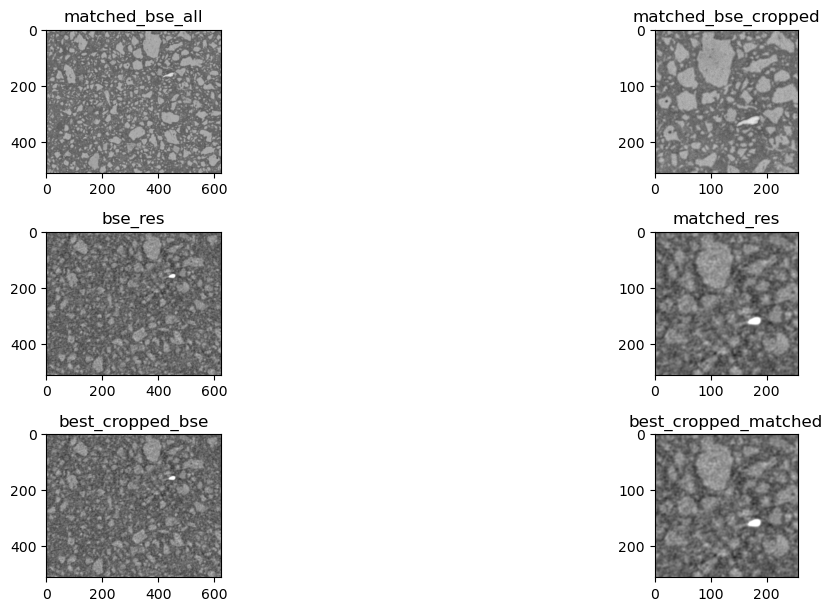

In [4]:
best_ct_img = Tools.get_ct_img(config.cement_sample_index, best_cropped_index)
best_cropped_matched_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_cropped_rect
                                   )
best_cropped_bse_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_bse_rect
                                   )

VisualizeData.show_imgs([matched_bse_img, matched_bse_cropped_img, 
                         cropped_bse_res, cropped_matched_res,
                           best_cropped_bse_res, best_cropped_matched_res], 
                           ["matched_bse_all", "matched_bse_cropped", 
                            "bse_res", "matched_res",
                            "best_cropped_bse", "best_cropped_matched"])

In [ ]:
# Step 2. 基于patch的配准的具体实现逻辑呢



